In [36]:
NAME = 'conv-labiturient'

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras import losses

import matplotlib.pyplot as plt

In [38]:
import datetime

In [39]:
import mydata as md

data = md.Data('cache')


In [40]:
raw_train_ds, raw_valid_ds, raw_test_ds = data.load('tabiturient')

In [41]:
max_features = 20000
sequence_length = 1000

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [42]:
vectorize_layer.adapt(raw_train_ds.map(lambda x,y: x))

In [43]:
train_ds = data.vectorize(raw_train_ds, vectorize_layer)
valid_ds = data.vectorize(raw_valid_ds, vectorize_layer)
test_ds = data.vectorize(raw_test_ds, vectorize_layer)


In [44]:
train_ds_batch=train_ds.shuffle(len(train_ds), reshuffle_each_iteration=True).batch(64)
valid_ds_batch=valid_ds.batch(64)
test_ds_batch=test_ds.batch(64)


In [52]:
embedding_dim=64

embedding_layer = tf.keras.layers.Embedding(
    input_dim=(max_features),
    output_dim=embedding_dim,
    mask_zero=True
)

model = tf.keras.Sequential([
    keras.Input(shape=(None,), dtype="int64"),
    embedding_layer,
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, kernel_regularizer=None)
])
model.summary()

model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),
              optimizer='rmsprop',
              metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

/home/alex/ai_venv_2/lib/python3.12/site-packages/keras/src/layers/layer.py:881: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, None, 64)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,707 (4.95 MB)

 Trainable params: 1,296,707 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
checkpoint_filepath = f"models/checkpoint_{NAME}.weights.h5"

log_dir = f"logs/fit-{NAME}/{datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")}"

epochs = 10
history = model.fit(
    train_ds_batch,
    validation_data=valid_ds_batch,
    epochs=epochs,
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_weights_only=True,
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.4180 - f1_score: 0.2685 - loss: 1.0713 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 1.0028
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.4957 - f1_score: 0.2421 - loss: 1.0387 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9841
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.4770 - f1_score: 0.2661 - loss: 1.0385 - val_accuracy: 0.5181 - val_f1_score: 0.2275 - val_loss: 0.9515
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.5402 - f1_score: 0.3356 - loss: 0.9823 - val_accuracy: 0.6017 - val_f1_score: 0.3838 - val_loss: 0.9063
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5688 - f1_score: 0.3831 - loss: 0.9378 - val_accuracy: 0.6630 - val_f1_score: 0.4525 - val_loss: 0.8506
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.6256 - f1_score: 0.4497 - loss: 0.8833 - val_accuracy: 0.7159 - val_f1_score: 0.5058

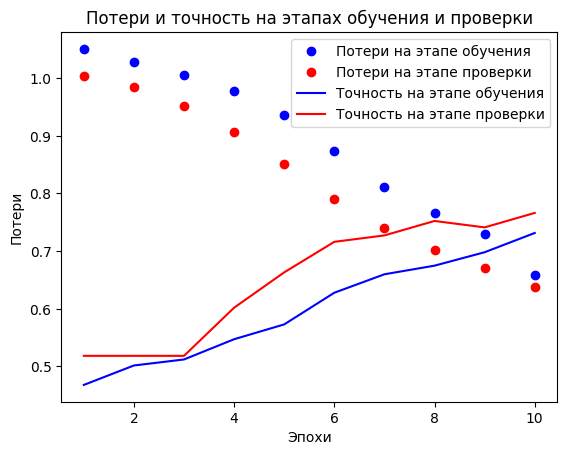

In [54]:
data.plot(history)

In [55]:
model.load_weights(checkpoint_filepath)

In [56]:
model.evaluate(test_ds_batch)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7125 - f1_score: 0.5368 - loss: 0.6993


[0.7043987512588501, 0.7083333134651184, 0.5435510277748108]

In [60]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  tf.keras.layers.Activation('softmax')
])

export_model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=False), optimizer="rmsprop", metrics=['accuracy', 'F1Score']
)

export_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ ?                      │     1,296,707 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,707 (4.95 MB)

 Trainable params: 1,296,707 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
export_model.save(f"models/export-model-{NAME}.keras")